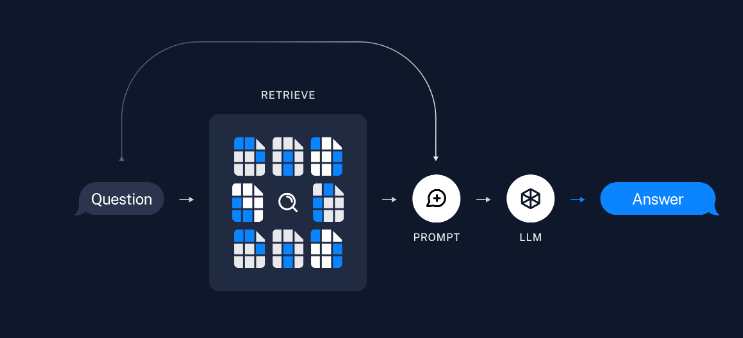

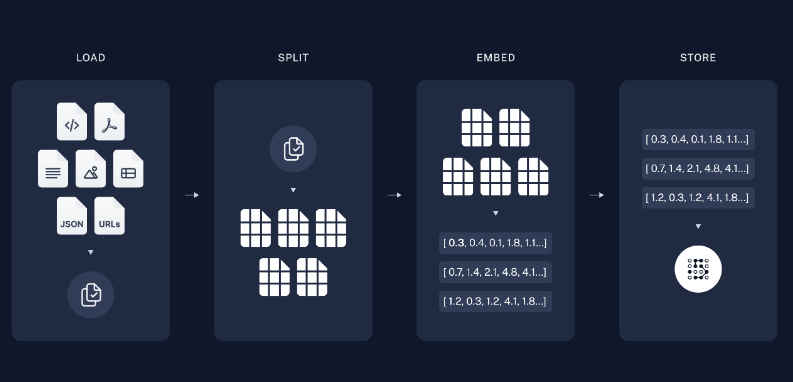

## Setup

In [109]:
!pip install --quiet langchain langchain-community langchainhub langchain-openai langchain-chroma bs4 datasets evaluate

In [110]:
from google.colab import userdata

## Load text data


### crawl webpage content

In [111]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
# https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html
# default parser: bs4, parse webcontent (basically remove html tags)
loader = WebBaseLoader(web_path="https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html",
                       bs_kwargs = dict(parse_only=bs4.SoupStrainer(
                          class_=("py method")
                       )))
# TODO: explain what is "document" here,
# ref: https://api.python.langchain.com/en/latest/documents/langchain_core.documents.base.Document.html#langchain_core.documents.base.Document
docs = loader.load()

In [112]:
print(len(docs))

1


In [113]:
print(vars(docs[0]).keys())

dict_keys(['page_content', 'metadata', 'type'])


### Try it now (5 mins)
check the metadata.  
check the page_content and length of page_content.  
(Before splitting the document, you need to know the average "block size")

### answer

In [ ]:
#check the metadata
print(docs[0].metadata)

{'source': 'https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html'}


In [ ]:
#calculate the length of page_content
print(len(docs[0].page_content))

2835


In [ ]:
docs[0].page_content

"\n\n__init__(web_path: Union[str, Sequence[str]] = '', header_template: Optional[dict] = None, verify_ssl: bool = True, proxies: Optional[dict] = None, continue_on_failure: bool = False, autoset_encoding: bool = True, encoding: Optional[str] = None, web_paths: Sequence[str] = (), requests_per_second: int = 2, default_parser: str = 'html.parser', requests_kwargs: Optional[Dict[str, Any]] = None, raise_for_status: bool = False, bs_get_text_kwargs: Optional[Dict[str, Any]] = None, bs_kwargs: Optional[Dict[str, Any]] = None, session: Optional[Any] = None) → None[source]Â¶\nInitialize loader.\n\nParameters\n\nweb_paths (Sequence[str]) â€“ Web paths to load from.\nrequests_per_second (int) â€“ Max number of concurrent requests to make.\ndefault_parser (str) â€“ Default parser to use for BeautifulSoup.\nrequests_kwargs (Optional[Dict[str, Any]]) â€“ kwargs for requests\nraise_for_status (bool) â€“ Raise an exception if http status code denotes an error.\nbs_get_text_kwargs (Optional[Dict[str

### Text spiltter

In [114]:
# split long text
# all of the text splitter are listed here: https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/
from langchain_text_splitters import RecursiveCharacterTextSplitter

#You can calculate the average string length as your chunk size
#Chunk_overlap would be better with half of average string length
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=512,
    add_start_index=True # TODO: explain parameter, ref: https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html
)
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))

4


In [115]:
split_docs[0].page_content

"__init__(web_path: Union[str, Sequence[str]] = '', header_template: Optional[dict] = None, verify_ssl: bool = True, proxies: Optional[dict] = None, continue_on_failure: bool = False, autoset_encoding: bool = True, encoding: Optional[str] = None, web_paths: Sequence[str] = (), requests_per_second: int = 2, default_parser: str = 'html.parser', requests_kwargs: Optional[Dict[str, Any]] = None, raise_for_status: bool = False, bs_get_text_kwargs: Optional[Dict[str, Any]] = None, bs_kwargs: Optional[Dict[str, Any]] = None, session: Optional[Any] = None) → None[source]Â¶\nInitialize loader.\n\nParameters"

### load HuggingFace dataset

In [116]:
import datasets
from datasets import load_dataset

dataset = load_dataset("MediaTek-Research/TCEval-v2", 'drcd')
clean_test = dataset['test'].to_pandas()
clean_test = clean_test[clean_test['references'].apply(len)==1]
clean_test['references'] = clean_test['references'].apply(lambda x: x[0])
clean_test = clean_test.rename(columns={"paragraph":"context", "references":"answer"})
clean_test = clean_test[:100].copy(deep=True).reset_index(drop=True)
clean_test = clean_test.sample(frac=1).reset_index(drop=True)
len(clean_test)

100

In [132]:
# build documents as from raw text
docs = []
from langchain.docstore.document import Document
for _, record in clean_test.iterrows():
    docs.append(Document(page_content=record['context'], metadata={"id": record['id']}))

In [133]:
docs[0]

Document(page_content='北印度和巴基斯坦的印度河文明被認為是最早發展都市計畫的文明。公元前2600年數千哈拉帊居民突然出現在城市之中，而這突然出現的人顯然是被計畫，外力所致的結果。某些居民顯然被安排要迎合一個有意識的，刻意安排的計畫。大城如摩亨約-達羅和哈拉巴的街道也以完美的經緯所呈現，足以與現今的紐約市所相媲美。房子被設計為預防噪音，臭味以及小偷。這些都市也被發現擁有世界上第一個都市公共衛生系統。公元前408年希臘的希波丹姆通常被認為是西方的都市計畫之父，他所設計的米利都，雖然古老卻是古都市計畫的範本。古羅馬在都市計畫中使用了鞏固為目標的藍圖，用來發展軍事防禦以及居民的便利性。許多歐洲都市至今仍然保持這些結構的的要素，如杜林。', metadata={'id': 'test-104'})

## Embedding model

### OpenAI embedding

In [119]:
from langchain_openai import AzureOpenAIEmbeddings


embed_func = AzureOpenAIEmbeddings(deployment="text-embedding-3-large",
                               openai_api_key=userdata.get('mtk-open-key'),
                               azure_endpoint='https://mtknycuragwebinar.openai.azure.com/',
                               openai_api_version='2024-05-01-preview',
                               max_retries=10,
                               chunk_size=1024,
                               show_progress_bar=True)

In [120]:
embedded_sentence = embed_func.embed_query("MTK")
print(len(embedded_sentence))

  0%|          | 0/1 [00:00<?, ?it/s]

3072


In [121]:
embedded_sentence[:5] # this will have 3072 numbers total

[0.0017592256190255284,
 -0.007628347259014845,
 -0.007084390614181757,
 -0.009670344181358814,
 -0.01669861190021038]

In [122]:
embedded_sentence = embed_func.embed_query("This is a test sentence.")
print(len(embedded_sentence))

  0%|          | 0/1 [00:00<?, ?it/s]

3072


In [123]:
embedded_documents = embed_func.embed_documents(["This is a test sentence.", "MTK"])
print(len(embedded_documents))
print(len(embedded_documents[0]))

  0%|          | 0/1 [00:00<?, ?it/s]

2
3072


## Vector store
- create database

In [134]:
# store vectors to chroma db
# chroma API doc: https://python.langchain.com/v0.1/docs/integrations/vectorstores/chroma/

# We have 100 documens now
# Transfer text in 100 documents into embedding
# insert the document and embedding into chroma database
from langchain_chroma import Chroma
# Be careful this will delete your database
Chroma().delete_collection()
vectorstore = Chroma.from_documents(documents=docs, embedding=embed_func)
print(len(vectorstore.get()['documents']))

100


In [150]:
clean_test.head()

,id,context,question,answer
0,test-104,北印度和巴基斯坦的印度河文明被認為是最早發展都市計畫的文明。公元前2600年數千哈拉帊居民突...,古都市計畫的範本是誰設計的？,希波丹姆
1,test-130,雖然多年的重建令灣仔失去了很多的歷史建築，但倘若小心察看，會發現灣仔的街道由南向北正好是香港...,綠屋位於灣仔的哪條街道？,茂蘿街
2,test-112,二次大戰後，美國國會1950年通過關島組織法，成立美式行政、立法、司法三權政府，並給予關島原...,關島議會在什麼時候砍了7席？,1999年
3,test-103,北印度和巴基斯坦的印度河文明被認為是最早發展都市計畫的文明。公元前2600年數千哈拉帊居民突...,擁有世界上首座都市公共衛生系統的城市可以和現在的什麼地方相比拚？,紐約市
4,test-4,波你尼所定義的梵語是從更早的「吠陀」形式演化出來的。學者經常把吠陀梵語和古典或「波你尼」梵語...,印度教的最早宗教文本以什麼語言撰寫？,吠陀梵語


- query database

In [149]:
 retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})
 q = clean_test.loc[25, 'question']
 print(q)
 retrieved_docs = retriever.invoke(q)
 retrieved_docs

新北市的哪一地區為直轄市山地原住民區？


[Document(page_content='新北市總人口中客家人口約佔14.1％，雖非全台灣最高，但總人口數為全台灣第二多，僅次於桃園市；新北市客家人分布較為分散，主要區域包括新莊、三重、三峽、新店安坑、汐止、泰山、五股、土城、深坑等地；另外東北角石門、金山一帶亦有少數客家人遷徙至當地定居。新北市的原住民人口佔總人口比例1.29%，以泰雅族為主，主要分布在烏來區；烏來區同時也是新北市唯一的直轄市山地原住民區。另外，新北市新住民人口約有九萬七千多人，為台灣新住民最多的城市，若把新住民子女及新移工納入，總人口數超過20萬人。另外中和區的華新街，為早期南洋華僑遷居來此地定居逐漸形成的聚落，尤其以緬甸人為主，每年「潑水節」活動為商圈重要節慶；永和區的中興街則為早期韓國華僑的聚集所在，又有『韓國街』之稱。', metadata={'id': 'test-49'}),
 Document(page_content='新北市位處副熱帶季風氣候區，全年雨量多而平均，月平均最低溫為一月份的攝氏12.4度，月平均最高溫發生於七月份的攝氏33.6度。全市極東點在貢寮區田寮洋子萊萊，位於東經122度01分26秒，北緯25度00分00秒；極西點在林口區小南灣下福，位於東經121度16分31秒，北緯24度40分05秒；極南點在烏來區棲蘭山，位於東經121度29分29秒，北緯24度40分51秒；極北點在石門區富貴角，位於東經121度31分00秒，北緯25度18分11秒；中心位置約在石碇區石碇里。作為典型的移民城市，新北市的族群分布呈現多元化的特色，堪稱台灣社會的縮影，目前新北市各族群中以閩南族為最多數，其中許多為早期北上就業的中南部移民後代，這些居民多居住於三重、新莊、蘆洲，溪南的中永和、新店居民則以1949年國民政府遷台後移入的外省人後代為主，但在近年新一波外來移民湧入後，此特色已不像若往明顯。', metadata={'id': 'test-76'}),
 Document(page_content='新北市位處副熱帶季風氣候區，全年雨量多而平均，月平均最低溫為一月份的攝氏12.4度，月平均最高溫發生於七月份的攝氏33.6度。全市極東點在貢寮區田寮洋子萊萊，位於東經122度01分26秒，北緯25度00分00秒；極西點在林口區小南灣下福，位於東經121度16分31秒，北緯24度40分05秒

In [136]:
from tqdm.notebook import tqdm
results = []
vectorstore.embeddings.show_progress_bar = False
for _, record in tqdm(clean_test.iterrows(), total=len(clean_test)):
  q = record['question']
  retrieved_docs = vectorstore.similarity_search_with_score(q, k=5)
  results.append(retrieved_docs)


  0%|          | 0/100 [00:00<?, ?it/s]

In [151]:
top1, top5 = 0,0
for i, result in enumerate(results):
  record = clean_test.iloc[i]
  gt = record['id']
  top1_pred = result[0][0].metadata['id']
  if top1_pred == gt:
    top1+=1
  for (doc, score) in result:
    pred = doc.metadata['id']
    if pred == gt:
      top5+=1
print(top5/len(results))
print(top1/len(results))

0.97
0.39


## Prepare prompts

In [152]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain_core.prompts import ChatPromptTemplate
# The basic unit of a conversation is message
# A message comes with "role" and "content"
# generally, there are only three roles in conversation: "system", "Human", "AI"
sys_message = SystemMessage(
    content=(
        "你是一個海盜，你會用有趣的腔調回答問題"
))
# you can format message with your variable
human_message = HumanMessagePromptTemplate.from_template("問題：{question}\n答案：")
human_message = human_message.format(question='2024NB總冠軍是哪一隊？')
# finally create chat with messages
full_prompt = [sys_message, human_message]
print(full_prompt)

[SystemMessage(content='你是一個海盜，你會用有趣的腔調回答問題'), HumanMessage(content='問題：2024NB總冠軍是哪一隊？\n答案：')]


In [153]:
from langchain_openai import AzureChatOpenAI
# chat openai https://api.python.langchain.com/en/latest/chat_models/langchain_openai.chat_models.azure.AzureChatOpenAI.html
llm = AzureChatOpenAI(
    openai_api_version='2024-05-01-preview',
    azure_deployment='gpt-4o',
    azure_endpoint='https://mtknycuragwebinar.openai.azure.com',
    openai_api_key=userdata.get('mtk-open-key'),
)

In [154]:
llm.invoke(full_prompt).content

'啊哈，船員！預測未來可不是老海盜的強項，特別是2024年的NBA總冠軍！我可沒那水晶球，也沒那能通靈的鸚鵡。不過，若你有心支持某隊，不妨搖旗吶喊，讓你心愛的隊伍在波濤洶湧的賽場上揚帆遠航！誰知呢，或許他們真能奪下那閃閃發光的冠軍寶座！揚帆起航吧，夥伴！🏴\u200d☠️🏀'

In [167]:
# you can also use ChatPromptTemplate to pack multiple messages, then do formatting
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "你是問答任務的助手。你只能使用檢索到的文章使用繁體中文來回答問題。如果你不知道答案，就說你不知道。"
            )
        ),
        HumanMessagePromptTemplate.from_template("問題：{question}\n文章：{context}\n答案："),
    ]
)
messages = chat_template.format_messages(question='2024NB總冠軍是哪一隊？', context='Context')
print(messages)

[SystemMessage(content='你是問答任務的助手。你只能使用檢索到的文章使用繁體中文來回答問題。如果你不知道答案，就說你不知道。'), HumanMessage(content='問題：2024NB總冠軍是哪一隊？\n文章：Context\n答案：')]


In [159]:
llm.invoke(messages).content

'我不知道。'

In [160]:
# Finally you can pull prompts from langchain hub, search prompts on https://smith.langchain.com/hub
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")
print(prompt.messages)
example_messages = prompt.format(
    context = "filler context1",
    question = "filler question1"
)
# this is give you a string
print(example_messages)

[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]
Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: filler question1 
Context: filler context1 
Answer:


## RAG: integrating LLM to generate


In [161]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=71aed2b360caf2d3cd43b3a24173395f4d64c7f01ddcce40c62524f203cbd651
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [163]:
import evaluate

rouge = evaluate.load('rouge') ## import the rouge scorer

for r, record in clean_test.iterrows():
  q = record['question']
  retrieved_docs = vectorstore.similarity_search_with_score(q, k=5)
  gt = record['answer']
  gt_doc_messages = chat_template.format_messages(question=q, context=record['context'])
  response1 = llm.invoke(gt_doc_messages)
  ret_doc_messages = chat_template.format_messages(question=q, context=retrieved_docs[0][0].page_content)
  response2 = llm.invoke(ret_doc_messages)
  break

In [164]:
rouge.compute(predictions=[response1.content],
              references=[gt],
              tokenizer=lambda x: [c for c in x]
)

{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}

## <font color="blue"> TODO 1 </font>

In [168]:
llm.invoke([HumanMessage("基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?")])

AIMessage(content='截至我最近的知識更新（2023年10月），我無法提供2024年NBA總冠軍賽的任何比賽結果，因為這些比賽尚未發生。請查閱最新的體育新聞和官方NBA網站以獲取最新的比賽結果和資訊。', response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 40, 'total_tokens': 111}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-f37659b9-a6cd-4f41-90cb-22b4f4a8976b-0', usage_metadata={'input_tokens': 40, 'output_tokens': 71, 'total_tokens': 111})

In [ ]:
# TODO 1
# step1: crawl web content from webpage
# step2: text splitter your web data
# step3: create vector store with embedding model
# step4: retrieve document from database
# step5: write your RAG prompt
# step6: ask LLM question with your RAG prompt

## Step 1: answer

In [ ]:

loader = WebBaseLoader(web_path="https://www.nytimes.com/athletic/5571475/2024/06/17/celtics-mavericks-nba-finals-game-5-score-result/")
docs = loader.load()

## Step2: Answer

In [ ]:
split_docs = text_splitter.split_documents(docs)
print(len(split_docs))

21


## Step 3: Answer

In [ ]:
vectorstore = Chroma.from_documents(documents=split_docs, embedding=embed_func)
print(len(vectorstore.get()['documents']))

  0%|          | 0/1 [00:00<?, ?it/s]

121


## Step 4: Answer

In [ ]:
q="基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?"
document=vectorstore.similarity_search_with_score(q, k=5)

  0%|          | 0/1 [00:00<?, ?it/s]

## Step 5: Answer

In [ ]:
sys_message = SystemMessage(
    content=(
        "你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答"
))
human_message = HumanMessagePromptTemplate.from_template("問題：{question}")
human_message = human_message.format(question='基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?'+str(document))
# finally create chat with messages
RAG_prompt = [sys_message, human_message]
print(RAG_prompt)

[SystemMessage(content='你是問答任務的助手。你只能使用檢索到的文章來回答問題。如果你不知道答案，就說你不知道。請盡量適用簡短的短語甚至單詞回答'), HumanMessage(content="問題：基於你的知識，塞爾提克在2024NBA總冠軍賽G5以多少分擊敗獨行俠?[(Document(page_content='pillars of this storied franchise.The Celtics beat the Dallas Mavericks 106-88 in Game 5 of the 2024 NBA Finals to win the series 4-1 and claim a league-record 18th NBA championship.AdvertisementA sea of green and white confetti fell from the rafters at TD Garden before Celtics coach Joe Mazzulla, the youngest coach in at least 48 years to win a title, hoisted the Larry O‚ÄôBrien Trophy. Most of Boston‚Äôs police force was stationed outside the arena with area bars ordered not to let anyone in after halftime and urged to board their doors and windows if the championship celebration got out of hand. An hour after the game, Celtic fans were climbing street lights on Causeway Street outside the arena.Why all the fuss for the NBA‚Äôs all-time greatest franchise? For the Celtics, it‚Äôd been a while. Boston ended a 16-yea

## Step 6: Answer

In [ ]:
llm.invoke(RAG_prompt).content

'106-88。'

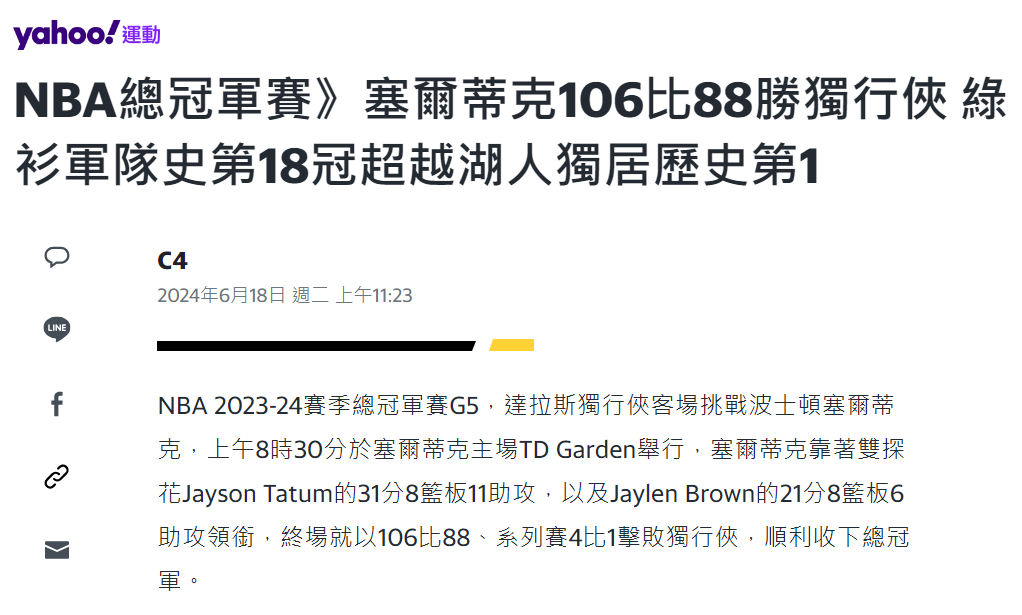

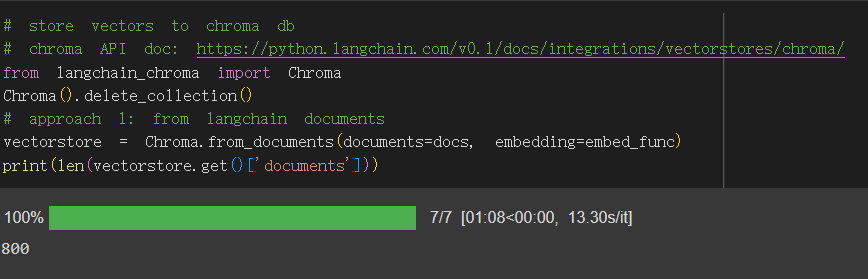

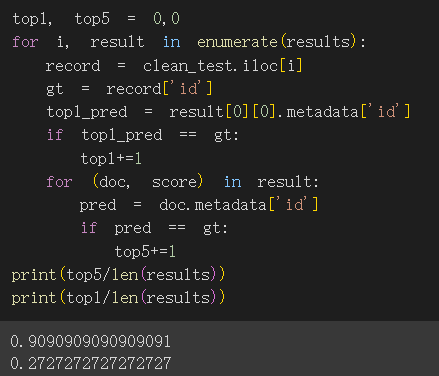

https://huggingface.co/spaces/mteb/leaderboard

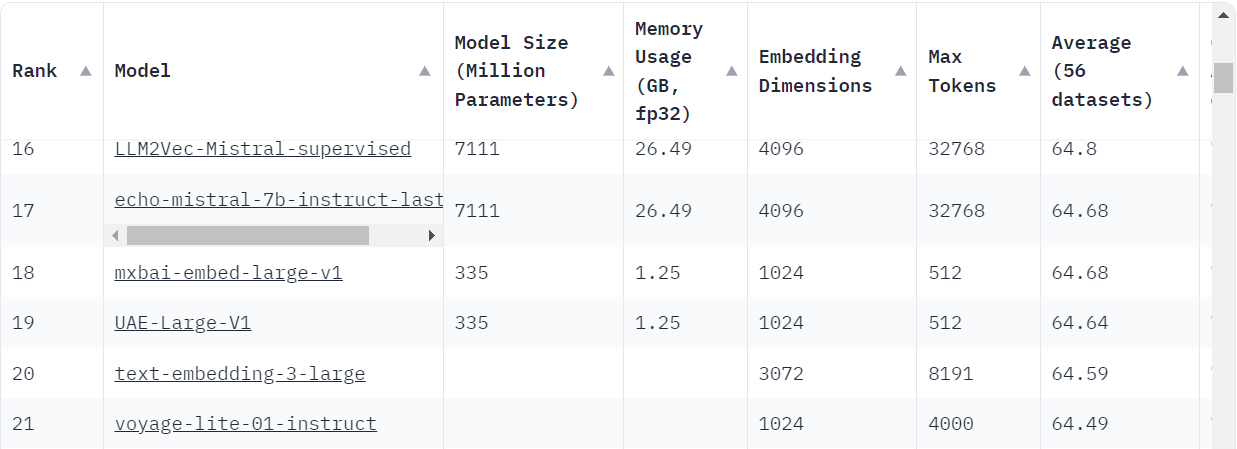

## (Advanced To do 2) change your embedding model and compare with openai embedding model performance

In [169]:
!pip install -q langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 99.2 MB/s eta 0:00:00


### 1. HuggingFace embedding model [API document](https://api.python.langchain.com/en/latest/embeddings/langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings.html).  
[MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

In [170]:
# This packs HF-model as a function
# TODO: explain embeddin gmodel, ref: https://api.python.langchain.com/en/latest/embeddings/langchain_core.embeddings.embeddings.Embeddings.html#langchain_core.embeddings.embeddings.Embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embed_func = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [171]:
from langchain_chroma import Chroma
# Be careful this will delete your database
Chroma().delete_collection()
vectorstore = Chroma.from_documents(documents=docs, embedding=embed_func)
print(len(vectorstore.get()['documents']))

100


In [172]:
from tqdm.notebook import tqdm
results = []
vectorstore.embeddings.show_progress = False
for _, record in tqdm(clean_test.iterrows(), total=len(clean_test)):
  q = record['question']
  retrieved_docs = vectorstore.similarity_search_with_score(q, k=5)
  results.append(retrieved_docs)

  0%|          | 0/100 [00:00<?, ?it/s]

You can see this model has lower hit-rate,    
and the accuracy can be lower if the database has more documents

In [173]:
top1, top5 = 0,0
for i, result in enumerate(results):
  record = clean_test.iloc[i]
  gt = record['id']
  top1_pred = result[0][0].metadata['id']
  if top1_pred == gt:
    top1+=1
  for (doc, score) in result:
    pred = doc.metadata['id']
    if pred == gt:
      top5+=1
print(top5/len(results))
print(top1/len(results))

0.47
0.12


### 2. Custom embedding model

if you have your own RAG dataset,   
you can fine-tune your own embedding model,  
here is how you can incorporate your model into langchain

In [ ]:
from langchain_core.embeddings import Embeddings
from typing import List
class CustomEmbeddings(Embeddings):
    def __init__(self):
        pass
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return [[0, 0, 0] for i in range(len(texts))]

    def embed_query(self, text: str) -> List[float]:
        return self.embed_documents([text])[0]

embed_func = CustomEmbeddings()

In [ ]:
embedded_sentence = embed_func.embed_query("This is a test sentence.")
print(len(embedded_sentence))

3
